In [1]:
import os
import numpy as np
from tensorflow.keras.applications import ResNet50  # Import ResNet model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import seaborn as sn

In [2]:
data_dir = r'C:\Users\haris\AI\ML\Projects\Data\Cars Dataset'

img_size = (224, 224)
batch_size = 32

def load_and_preprocess_data(subdir_name):
    images = []
    labels = []
    
    class_counts = {}

    class_folders = os.listdir(os.path.join(data_dir, subdir_name))
    num_classes = len(class_folders)

    for class_index, class_folder in enumerate(class_folders):
        class_path = os.path.join(data_dir, subdir_name, class_folder)
        num_samples = len(os.listdir(class_path))
        class_counts[class_folder] = num_samples

        for image_file in os.listdir(class_path):
            image_path = os.path.join(class_path, image_file)
            img = load_img(image_path, target_size=img_size)
            img_array = img_to_array(img)
            img_array /= 255.0
            images.append(img_array)
            labels.append(class_index)
    images = np.array(images)
    labels = to_categorical(labels, num_classes=num_classes)

    print("Class Representation:")
    for class_name, count in class_counts.items():
        print(f"{class_name}: {count} samples")

    return images, labels, num_classes

In [3]:
images, labels, num_classes = load_and_preprocess_data('train')
train_images, valid_images, train_labels, valid_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

Class Representation:
Audi: 814 samples
Hyundai Creta: 271 samples
Mahindra Scorpio: 316 samples
Rolls Royce: 311 samples
Swift: 424 samples
Tata Safari: 441 samples
Toyota Innova: 775 samples


Epoch 1/10
84/84 [==============================] - 17s 111ms/step - loss: 1.9762 - accuracy: 0.2410 - val_loss: 1.8349 - val_accuracy: 0.1952
Epoch 2/10
84/84 [==============================] - 8s 94ms/step - loss: 1.7971 - accuracy: 0.3047 - val_loss: 1.6687 - val_accuracy: 0.3621
Epoch 3/10
84/84 [==============================] - 8s 94ms/step - loss: 1.7220 - accuracy: 0.3562 - val_loss: 1.7576 - val_accuracy: 0.3711
Epoch 4/10
84/84 [==============================] - 8s 94ms/step - loss: 1.7343 - accuracy: 0.3439 - val_loss: 1.7023 - val_accuracy: 0.3785
Epoch 5/10
84/84 [==============================] - 8s 95ms/step - loss: 1.6604 - accuracy: 0.3752 - val_loss: 1.6605 - val_accuracy: 0.3815
Epoch 6/10
84/84 [==============================] - 8s 94ms/step - loss: 1.6625 - accuracy: 0.3801 - val_loss: 1.6096 - val_accuracy: 0.4024
Epoch 7/10
84/84 [==============================] - 8s 94ms/step - loss: 1.6486 - accuracy: 0.3667 - val_loss: 1.6084 - val_accuracy: 0.3949
Epoch 8/10


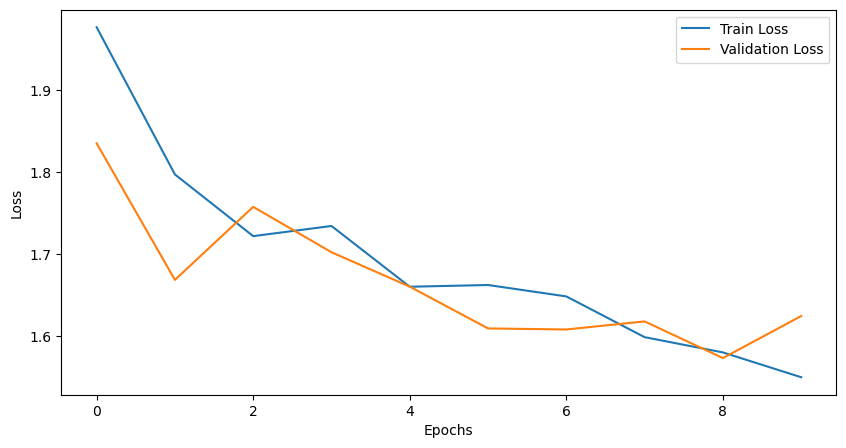

In [4]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=img_size + (3,))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_images,
    train_labels,
    validation_data=(valid_images, valid_labels),
    batch_size=batch_size,
    epochs=10,
)

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [5]:
test_images, test_labels, num_classes = load_and_preprocess_data('test')

test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

test_predictions = model.predict(test_images)
test_predictions_classes = np.argmax(test_predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

arr = confusion_matrix(true_classes, test_predictions_classes)

class_names = [str(i) for i in range(num_classes)]  # Use numeric class labels for the test dataset
classification_rep = classification_report(true_classes, test_predictions_classes, target_names=class_names)
print("Classification Report:\n", classification_rep)


Class Representation:
Audi: 199 samples
Hyundai Creta: 67 samples
Mahindra Scorpio: 75 samples
Rolls Royce: 74 samples
Swift: 102 samples
Tata Safari: 106 samples
Toyota Innova: 190 samples
26/26 [==============================] - 53s 2s/step - loss: 1.6133 - accuracy: 0.3715
Test Loss: 1.613271951675415
Test Accuracy: 0.37146371603012085
26/26 [==============================] - 3s 83ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.33      0.44       199
           1       0.83      0.15      0.25        67
           2       0.48      0.27      0.34        75
           3       0.00      0.00      0.00        74
           4       0.42      0.05      0.09       102
           5       0.27      0.44      0.34       106
           6       0.33      0.82      0.47       190

    accuracy                           0.37       813
   macro avg       0.43      0.29      0.27       813
weighted avg       0.44      0.37      

C:\Users\haris\anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\haris\anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\haris\anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

<AxesSubplot:>

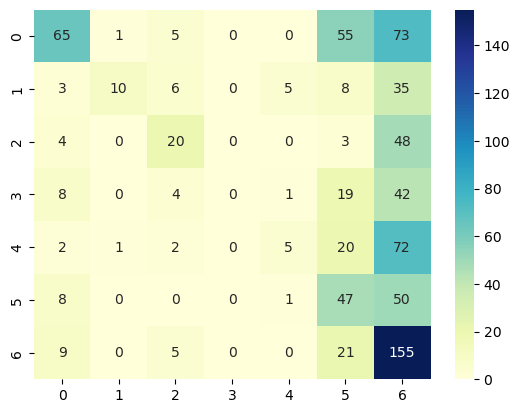

In [6]:
import seaborn as sn
df_cm = pd.DataFrame(arr, range(7), range(7))
sn.heatmap(df_cm, annot=True,fmt="d", cmap="YlGnBu") 